In [176]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox


In [177]:
? adfuller

Signature:
 adfuller(
    x,
    maxlag: 'int | None' = None,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False,
)
Docstring:
Augmented Dickey-Fuller unit root test.

The Augmented Dickey-Fuller test can be used to test for a unit root in a
univariate process in the presence of serial correlation.

Parameters
----------
x : array_like, 1d
    The data series to test.
maxlag : {None, int}
    Maximum lag which is included in test, default value of
    12*(nobs/100)^{1/4} is used when ``None``.
regression : {"c","ct","ctt","n"}
    Constant and trend order to include in regression.

    * "c" : constant only (default).
    * "ct" : constant and trend.
    * "ctt" : constant, and linear and quadratic trend.
    * "n" : no constant, no trend.

autolag : {"AIC", "BIC", "t-stat", None}
    Method to use when automatically determining the lag length among the
    values 0, 1, ..., maxlag.

    * If "AIC" (default) or "BIC", then the number of lags is chosen
      to

In [178]:
[i for i in dir( smt.graphics ) if i[:1] != '_']

['acf',
 'calendar',
 'deprecate_kwarg',
 'month_plot',
 'np',
 'pacf',
 'pd',
 'plot_acf',
 'plot_pacf',
 'plot_predict',
 'quarter_plot',
 'seasonal_plot',
 'utils']

In [179]:
? smt.graphics.plot_acf

Signature:
 smt.graphics.plot_acf(
    x,
    ax=None,
    lags=None,
    *,
    alpha=0.05,
    use_vlines=True,
    adjusted=False,
    fft=False,
    missing='none',
    title='Autocorrelation',
    zero=True,
    auto_ylims=False,
    bartlett_confint=True,
    vlines_kwargs=None,
    **kwargs,
)
Docstring:
Plot the autocorrelation function

Plots lags on the horizontal and the correlations on vertical axis.

Parameters
----------
x : array_like
    Array of time-series values
ax : AxesSubplot, optional
    If given, this subplot is used to plot in instead of a new figure being
    created.
lags : {int, array_like}, optional
    An int or array of lag values, used on horizontal axis. Uses
    np.arange(lags) when lags is an int.  If not provided,
    ``lags=np.arange(len(corr))`` is used.
alpha : scalar, optional
    If a number is given, the confidence intervals for the given level are
    returned. For instance if alpha=.05, 95 % confidence intervals are
    returned where the st

In [180]:
? smt.graphics.plot_pacf

Signature:
 smt.graphics.plot_pacf(
    x,
    ax=None,
    lags=None,
    alpha=0.05,
    method='ywm',
    use_vlines=True,
    title='Partial Autocorrelation',
    zero=True,
    vlines_kwargs=None,
    **kwargs,
)
Docstring:
Plot the partial autocorrelation function

Parameters
----------
x : array_like
    Array of time-series values
ax : AxesSubplot, optional
    If given, this subplot is used to plot in instead of a new figure being
    created.
lags : {int, array_like}, optional
    An int or array of lag values, used on horizontal axis. Uses
    np.arange(lags) when lags is an int.  If not provided,
    ``lags=np.arange(len(corr))`` is used.
alpha : float, optional
    If a number is given, the confidence intervals for the given level are
    returned. For instance if alpha=.05, 95 % confidence intervals are
    returned where the standard deviation is computed according to
    1/sqrt(len(x))
method : str
    Specifies which method for the calculations to use:

    - "ywm" or 

In [245]:
class DataSerie:
    '''Класс для стационирования и дифференцирования
    Стационарность оценивается функцией adfuller (в дополнение - plot_variation)
    Тренд, сезонность и цикличность - визуально по corellogram (в дополнение - plot_cycle, plot_autoregression)
    
    Шаги дифференцирования с помощью differencing
    И в конце данные восстанавливаются с прогнозом через predicting
    '''

    def __init__(self, data, name, size_predict=12):
        self.data = data
        self.memory = data
        self.name = name
        self.size_predict = size_predict
        self.diff_story = []

    def reset_data(self):
        '''Сброс преобразований'''
        self.data = self.memory.copy()

    def adfuller(self):
        '''Проверка на стационарность'''
        data = self.data
        af_t = adfuller(
            data,
            autolag='AIC',
            regresults=False
            )[:4]
        self.af = dict( zip( ['adf','pvalue','usedlag','nobs'], af_t ) )
        self.af['is_stacionar'] = self.af['pvalue'] < 0.05
        self.af['skew'] = np.mean( self.data )
        print(self.af)

    def plot(self):
        '''Просто график - можно рисовать версии между преобразованиями'''
        self.data.plot()
        plt.title(self.name)

    def plot_cycle(self, lags=12):
        '''График с точками по циклу'''
        for step in range(lags)[::3]:
            self.plot()
            self.data[step::lags].plot( style='o--', color='grey')
        plt.show();
    
    def plot_autoregression(self, lags=[1,12]):
        '''График регрессии данных к своему лагу'''
        fig, ax = plt.subplots(len(lags), 1, figsize=(5,len(lags)*5)  )
        for step in lags:
            cur_ax = ax[ lags.index(step) ]
            sns.regplot( x=ds.data[:-step], y=ds.data[step:], ax=cur_ax )
            cur_ax.set_xlabel('curently')
            cur_ax.set_ylabel(f'step {step}')
            cur_ax.set_title(f'Авторегрессия для шага {step}')


    def plot_variation(self):
        '''График вариациии гистограммой и бокс-плотом'''
        fig, ax = plt.subplots( 1,2, figsize=(20,5) )
        self.data.plot.hist( title=f' Среднее: {np.mean(self.data):.1f}, СКО:{np.std(self.data):.1%}, Вариация: {np.var(self.data):.1f}', ax=ax[0] );
        self.data.plot.box( title=f' Q1: {np.percentile(self.data, 25):.1f}, Me:{np.percentile(self.data, 50):.1f}, Q3:{np.percentile(self.data, 75):.1f}', ax=ax[1] );


    def corellogram(self, figsize=(14,8), lags=None):
        '''График кореллограммы'''
        plt.figure(figsize=figsize)
        layout=(4,1)
        ts_ax = plt.subplot2grid( layout, (0,0), rowspan=2 )
        acf_ax = plt.subplot2grid( layout, (2,0) )
        pacf_ax = plt.subplot2grid( layout, (3,0) )
        self.data.plot( ax=ts_ax, color='blue', title=self.name )
        
        smt.graphics.plot_acf( self.data, lags=lags, ax=acf_ax, alpha=0.05 )
        smt.graphics.plot_pacf( self.data, lags=lags, ax=pacf_ax, alpha=0.05 )
        plt.tight_layout( )
        

    def differencing(self, n_dif):
        '''Дифференцирование по выбранному шагу
        Вычисляет новый ряд и записывает данные для восстановления'''
        self.diff_story.append( [ n_dif, self.data[:n_dif] ] )
        self.data = self.data[n_dif:].reset_index(drop=True) - self.data[:-n_dif].reset_index(drop=True)
        self.data.index = [i+n_dif for i in self.data.index]



    def predicting(self, size_predict=12):
        '''Прогноз с выбранным шагом
        Продлевает ряд, восстанавливает его и даёт график в сравнении с изначальными данными'''

        # Из полученного, предположительно стационарного ряда,
        # Делается нормальное распределение и перемешивается
        self.size_predict = size_predict
        dat_for_predict = self.data.copy()
        dat = np.random.choice( dat_for_predict, size=len( dat_for_predict  ), replace=True )
        loc = np.mean( dat )
        scale = np.std( dat )
        size = size_predict
        self.add_list = np.random.normal(loc, scale, size)
        np.random.shuffle( self.add_list )
        
        # Прогнозные данные добавляются к ряду данных
        for i in self.add_list:
            dat_for_predict[ max( dat_for_predict.index )+1 ] = i 
        self.predict = dat_for_predict

        # Восстановление изначальных данных по шагам дифференцирования
        for n_step, predict_start in self.diff_story[::-1]:
            d = []
            d.extend(  predict_start )

            for i in self.predict:
                d.append( d[-n_step]+i )

            self.predict = d.copy()
        
        # Графики
        plt.plot( self.predict, linestyle='--', color='red' )
        plt.plot( self.memory, linestyle='-', color='black' )
        plt.show();

In [184]:
file_names = [
'monthly-sales-of-company-x-jan-6.csv',
'monthly-boston-armed-robberies-j.csv',
'international-airline-passengers.csv',
'mean-monthly-air-temperature-deg.csv',
'weekly-closings-of-the-dowjones-.csv',
'daily-total-female-births-in-cal.csv'
]

Пример 1

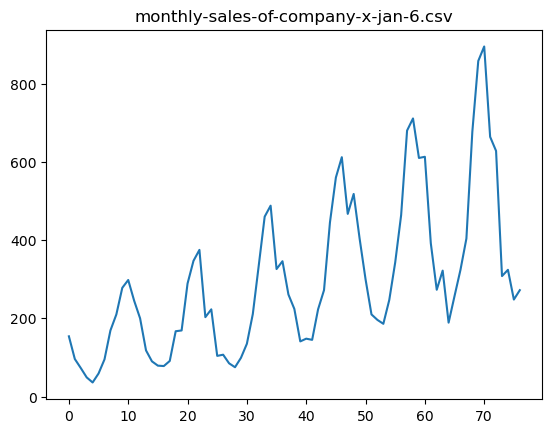

In [185]:
file_name = file_names[0]
ds_1 = pd.read_csv(file_name)
ds = DataSerie( ds_1['Count'], file_name )
ds.plot()

{'adf': -10.927221489002742, 'pvalue': 1.0030851132917177e-19, 'usedlag': 0, 'nobs': 52, 'is_stacionar': True, 'skew': 1.8867924528301887}


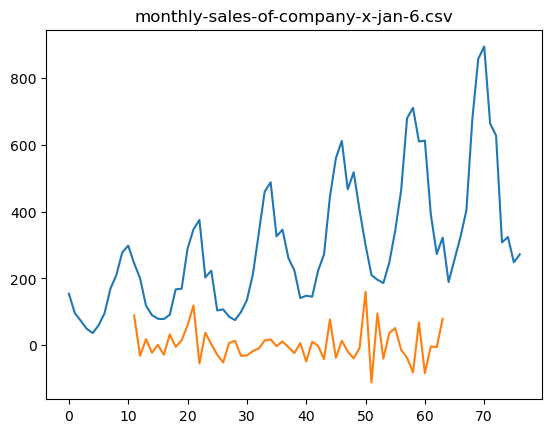

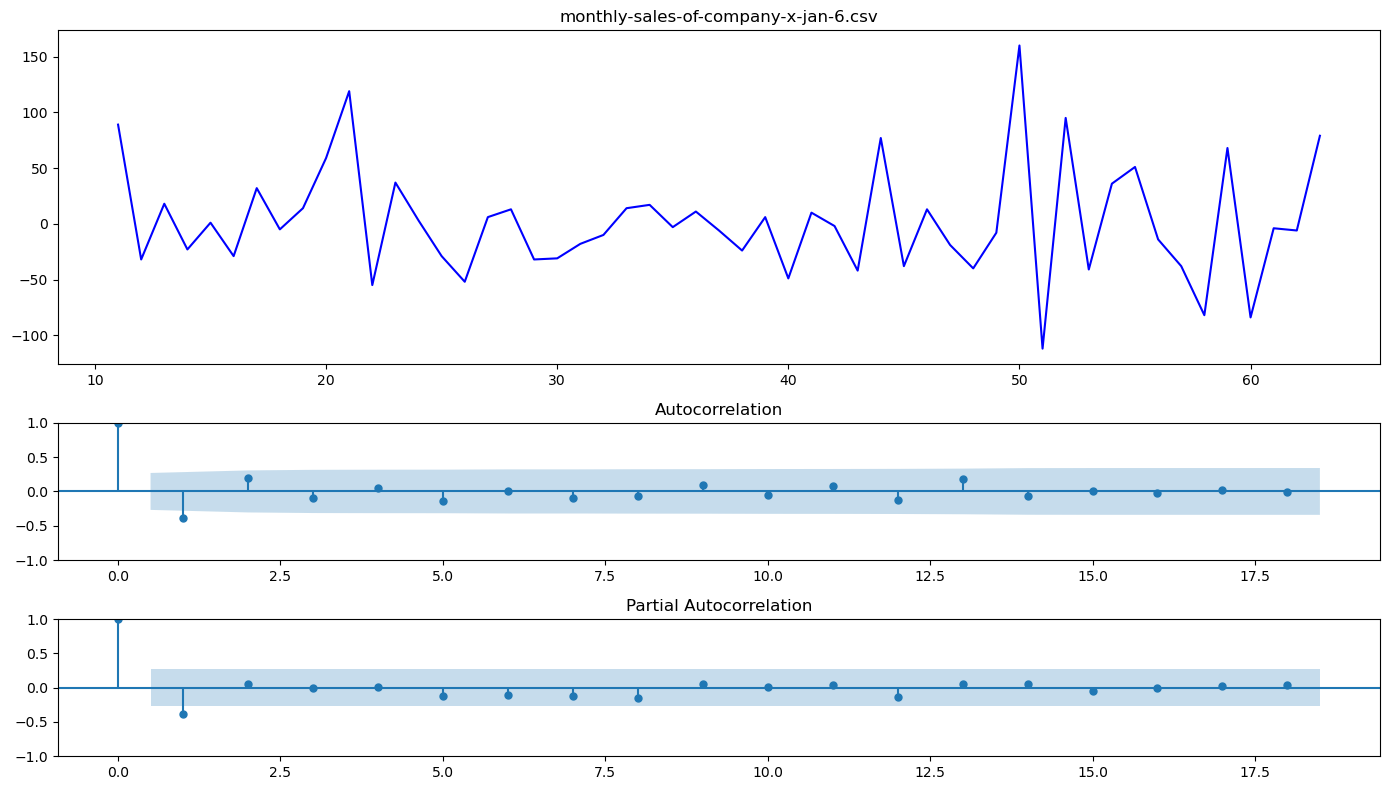

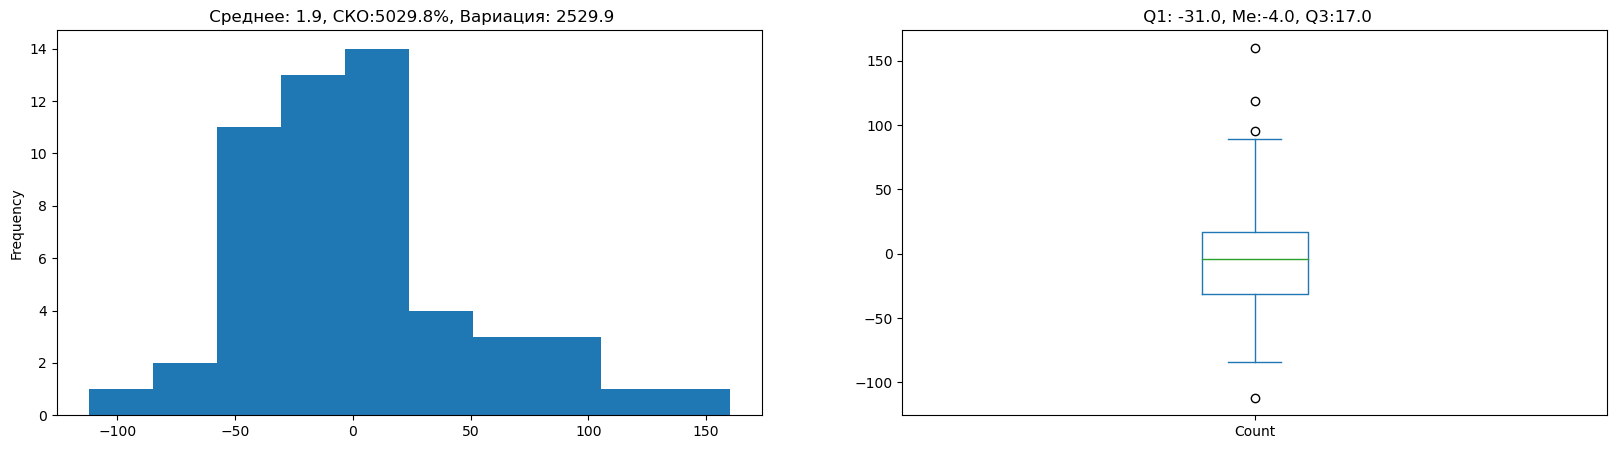

In [186]:
ds.plot()
ds.differencing(1)
ds.differencing(12)
ds.differencing(11)
ds.plot()

ds.adfuller()
plt.show();

ds.corellogram()

ds.plot_variation()

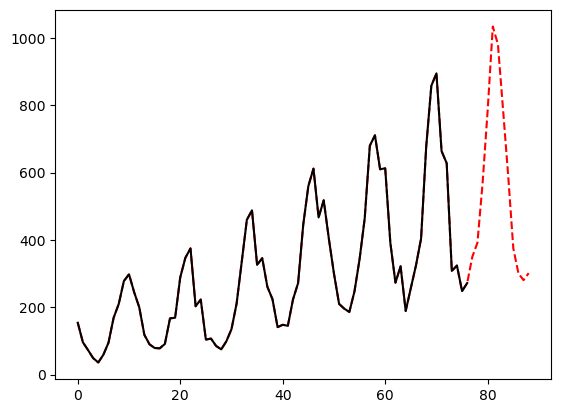

In [187]:
ds.predicting(size_predict=12)

Пример 2

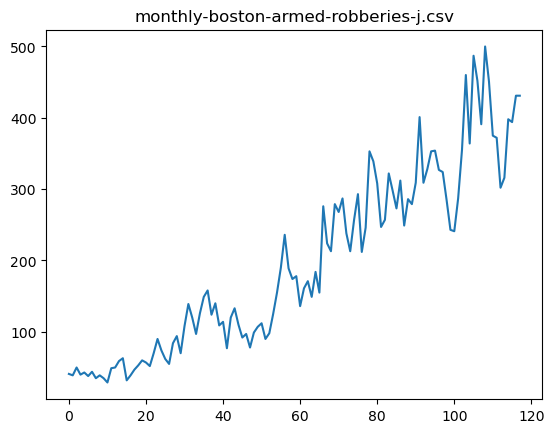

In [188]:
file_name = file_names[1]
ds_1 = pd.read_csv(file_name)
ds = DataSerie( ds_1['Count'], file_name )
ds.plot()

{'adf': 1.0011021402458182, 'pvalue': 0.9942775638057234, 'usedlag': 11, 'nobs': 106, 'is_stacionar': False, 'skew': 196.28813559322035}


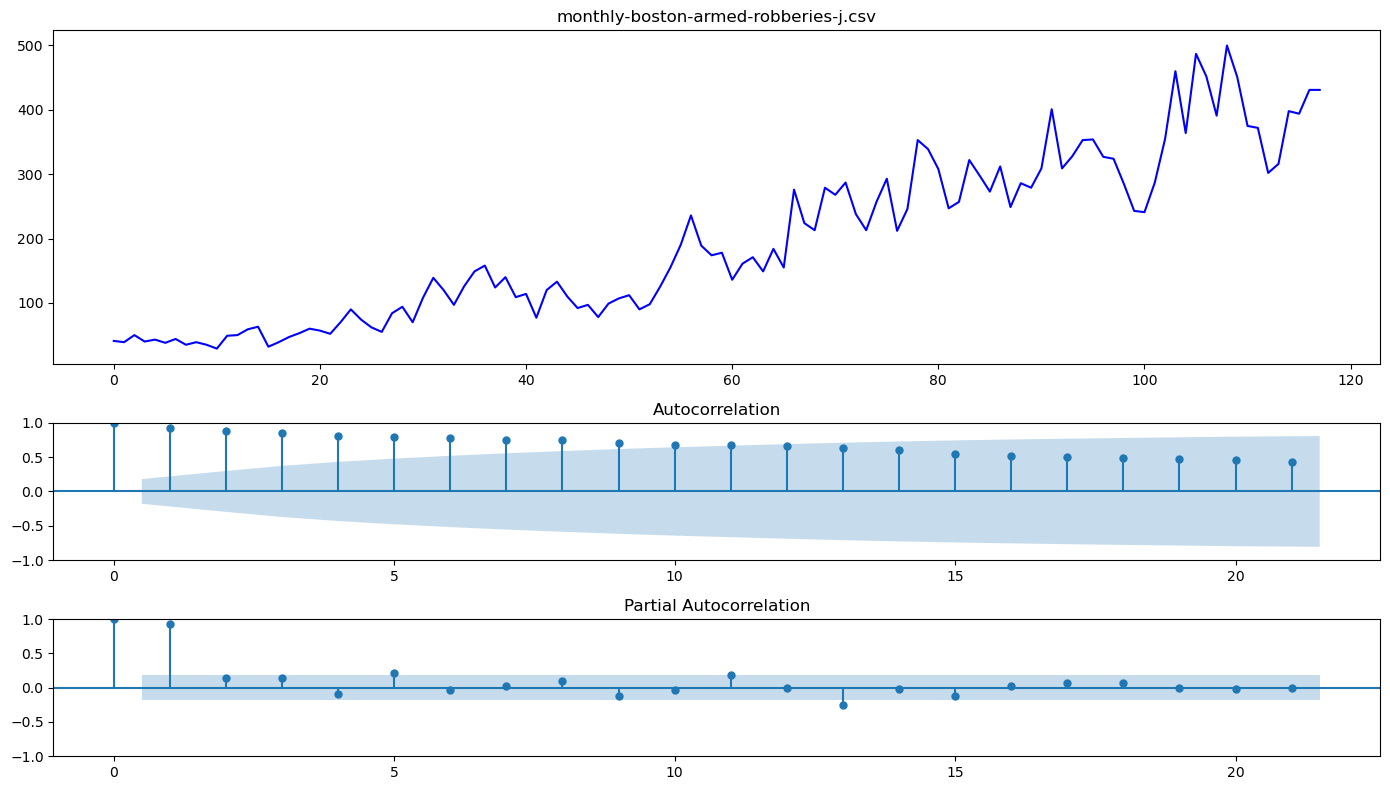

In [189]:
ds.adfuller()
ds.corellogram()

{'adf': -7.428564475067204, 'pvalue': 6.45079541268687e-11, 'usedlag': 10, 'nobs': 106, 'is_stacionar': True, 'skew': 3.3333333333333335}


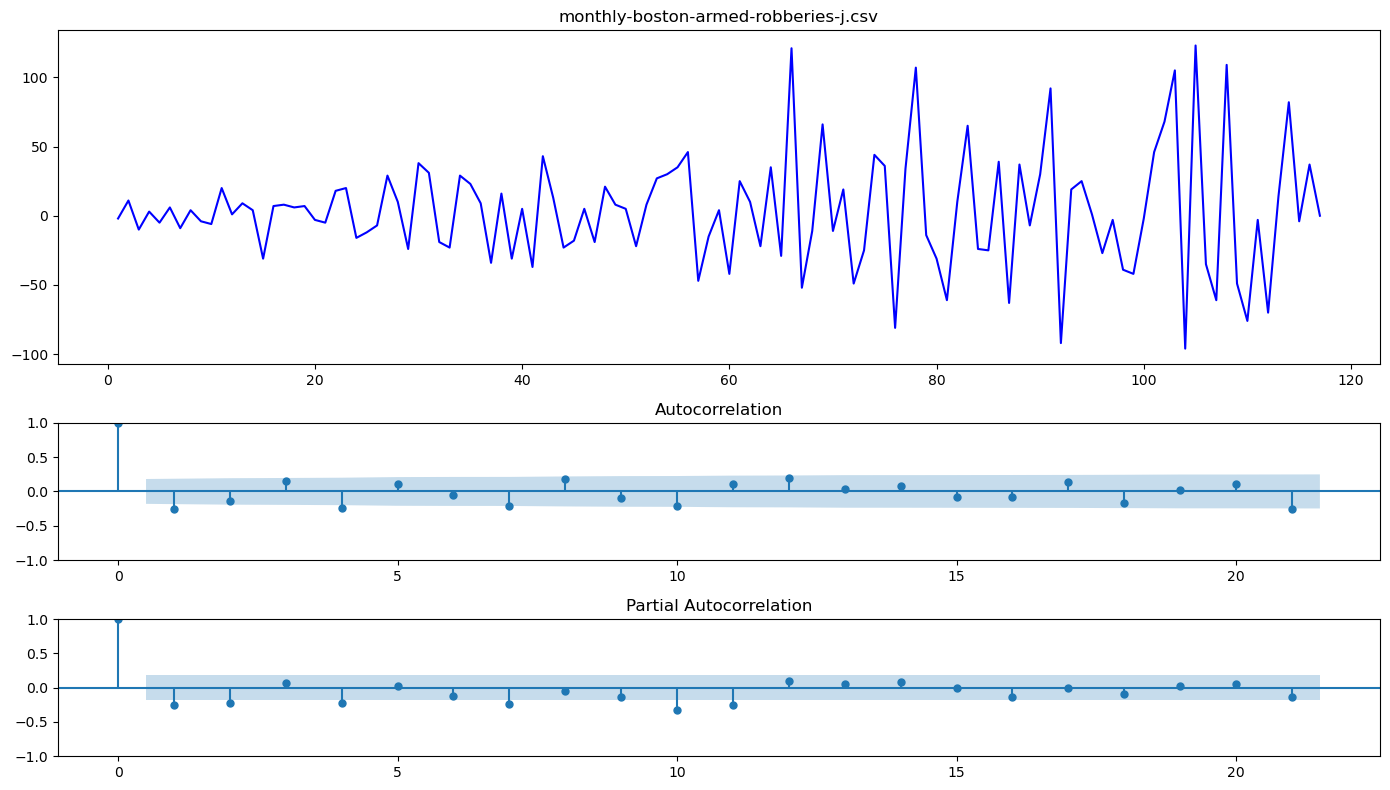

In [190]:
ds.differencing(1)
ds.adfuller()
ds.corellogram()

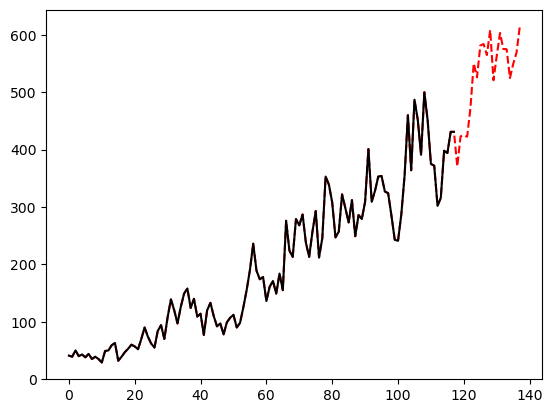

In [191]:
ds.predicting(20)

Пример 3

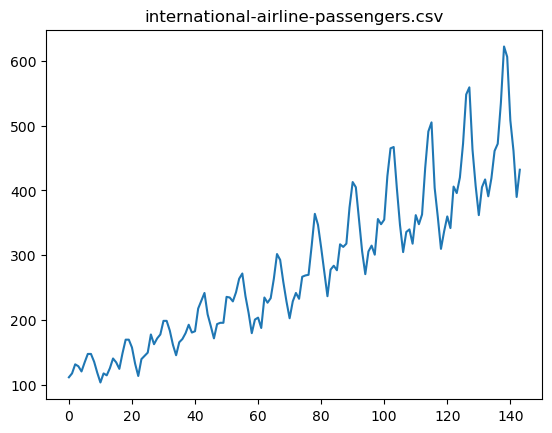

In [192]:
file_name = file_names[2]
ds_1 = pd.read_csv(file_name)
ds = DataSerie( ds_1['Count'], file_name )
ds.plot()

{'adf': 0.8153688792060597, 'pvalue': 0.9918802434376411, 'usedlag': 13, 'nobs': 130, 'is_stacionar': False, 'skew': 280.2986111111111}


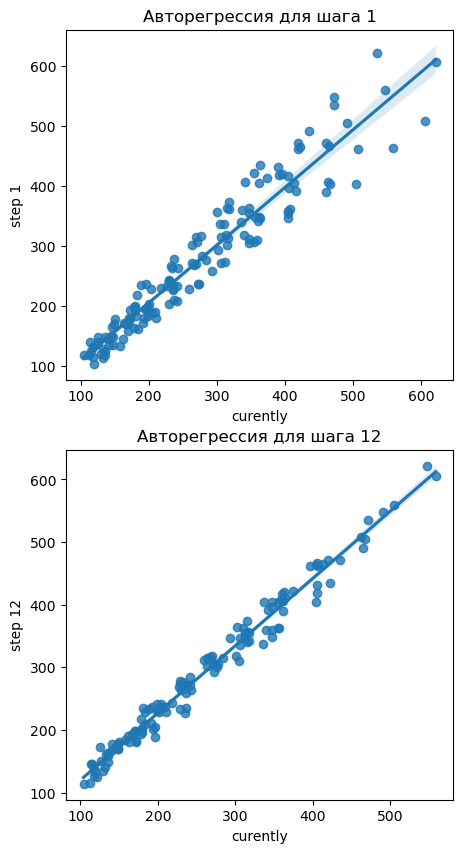

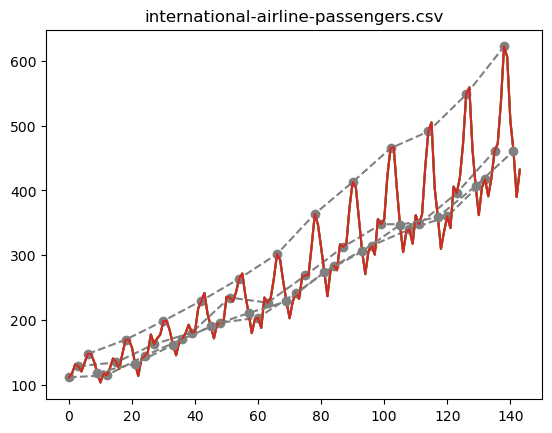

In [193]:
ds.adfuller()
ds.plot_autoregression(lags=[1,12])
plt.show();
ds.plot_cycle(12)

In [194]:
ds = DataSerie( ds_1['Count'], file_name )
ds.differencing(12)
ds.adfuller()

{'adf': -3.3830207264924805, 'pvalue': 0.011551493085514982, 'usedlag': 1, 'nobs': 130, 'is_stacionar': True, 'skew': 31.772727272727273}


In [195]:
ds = DataSerie( ds_1['Count'], file_name )
ds.differencing(12)
ds.differencing(1)
ds.adfuller()

{'adf': -15.595618083746338, 'pvalue': 1.856511600123444e-28, 'usedlag': 0, 'nobs': 130, 'is_stacionar': True, 'skew': 0.183206106870229}


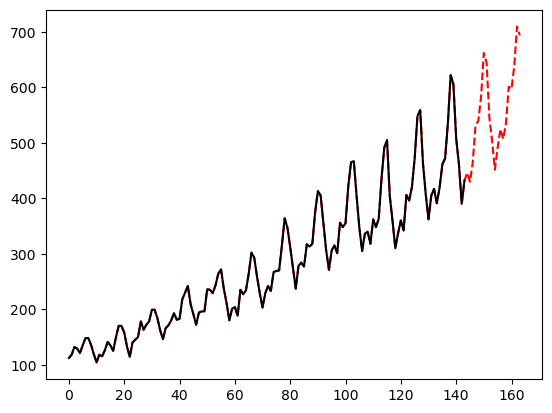

In [196]:
ds.predicting(20)

Пример 4

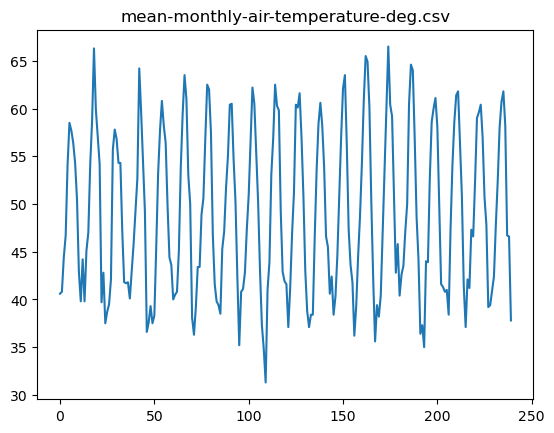

In [213]:
file_name = file_names[3]
ds_1 = pd.read_csv(file_name)
ds = DataSerie( ds_1['Deg'], file_name )
ds.plot()

In [214]:
ds.adfuller()

{'adf': -3.2554924030863446, 'pvalue': 0.016989030222608236, 'usedlag': 14, 'nobs': 225, 'is_stacionar': True, 'skew': 49.04125}


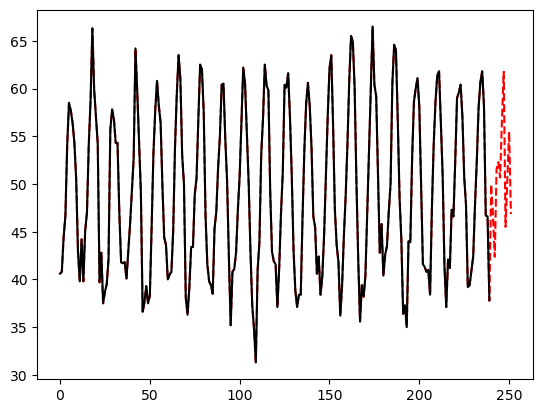

In [215]:
ds.predicting()

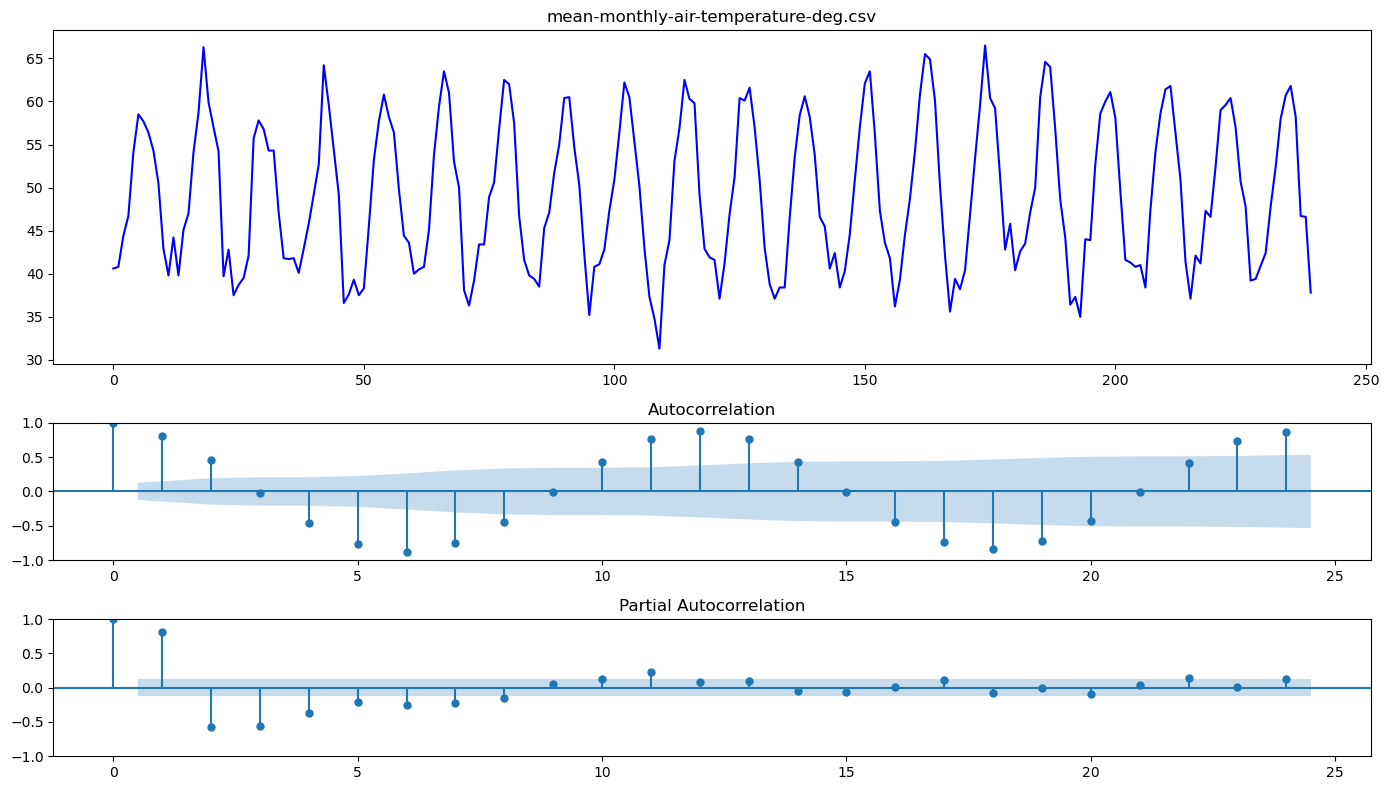

In [216]:
ds.corellogram()

Пример 5

Index(['Week', 'Close'], dtype='object')


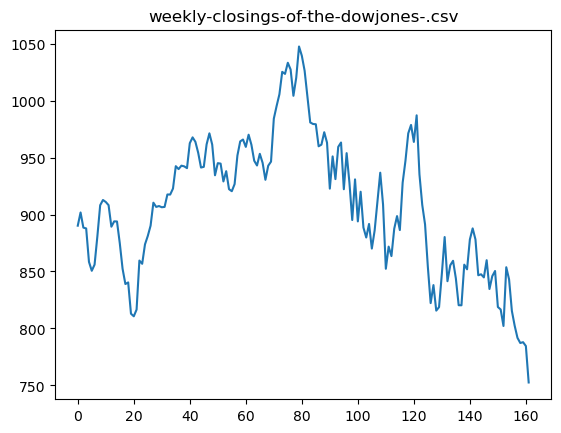

In [217]:
file_name = file_names[4]
ds_1 = pd.read_csv(file_name)
print( ds_1.columns )
ds = DataSerie( ds_1['Close'], file_name )
ds.plot()

{'adf': -1.314625498491169, 'pvalue': 0.6224548515589731, 'usedlag': 0, 'nobs': 161, 'is_stacionar': False, 'skew': 907.4847530864199}


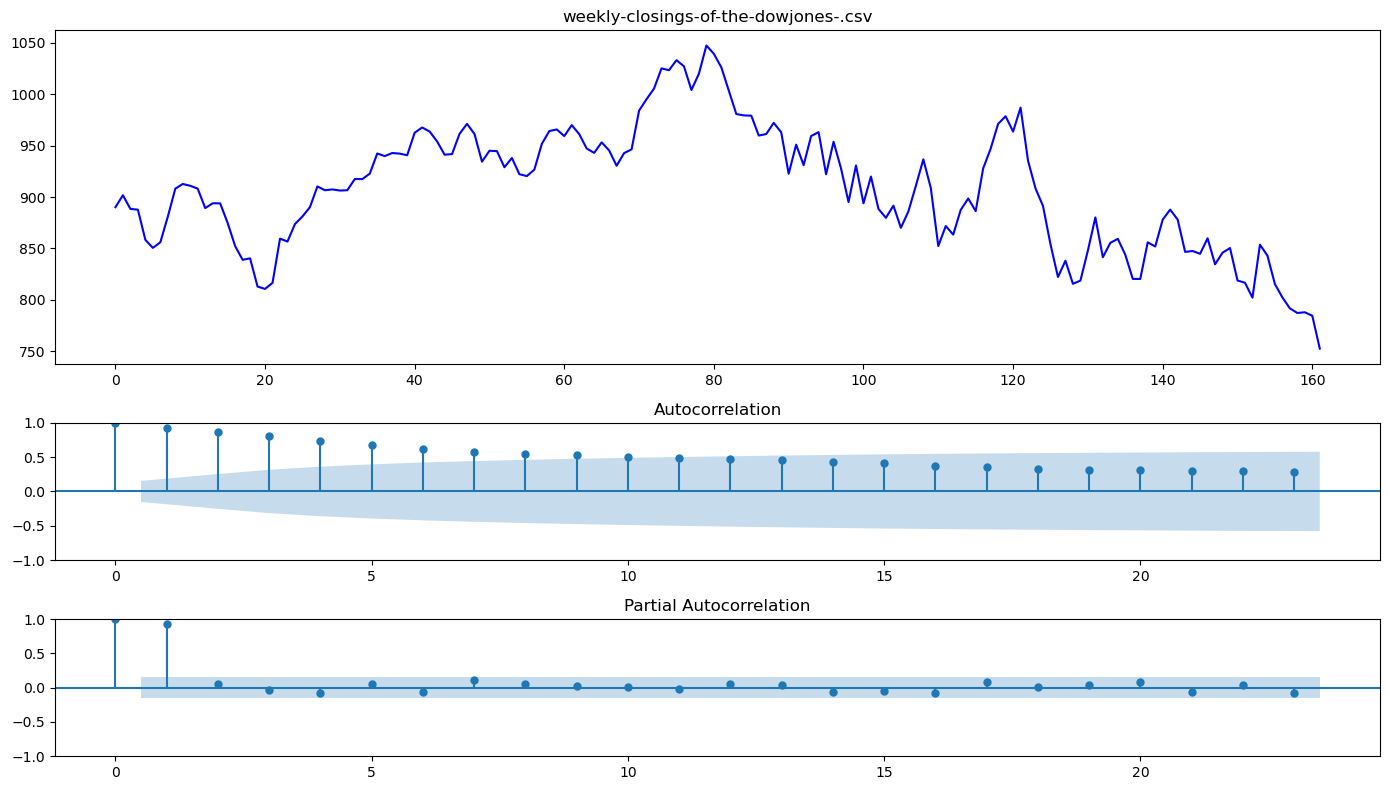

In [218]:
ds.adfuller()
ds.corellogram()

{'adf': -13.025207881234952, 'pvalue': 2.4075864037416927e-24, 'usedlag': 0, 'nobs': 160, 'is_stacionar': True, 'skew': -0.85472049689441}


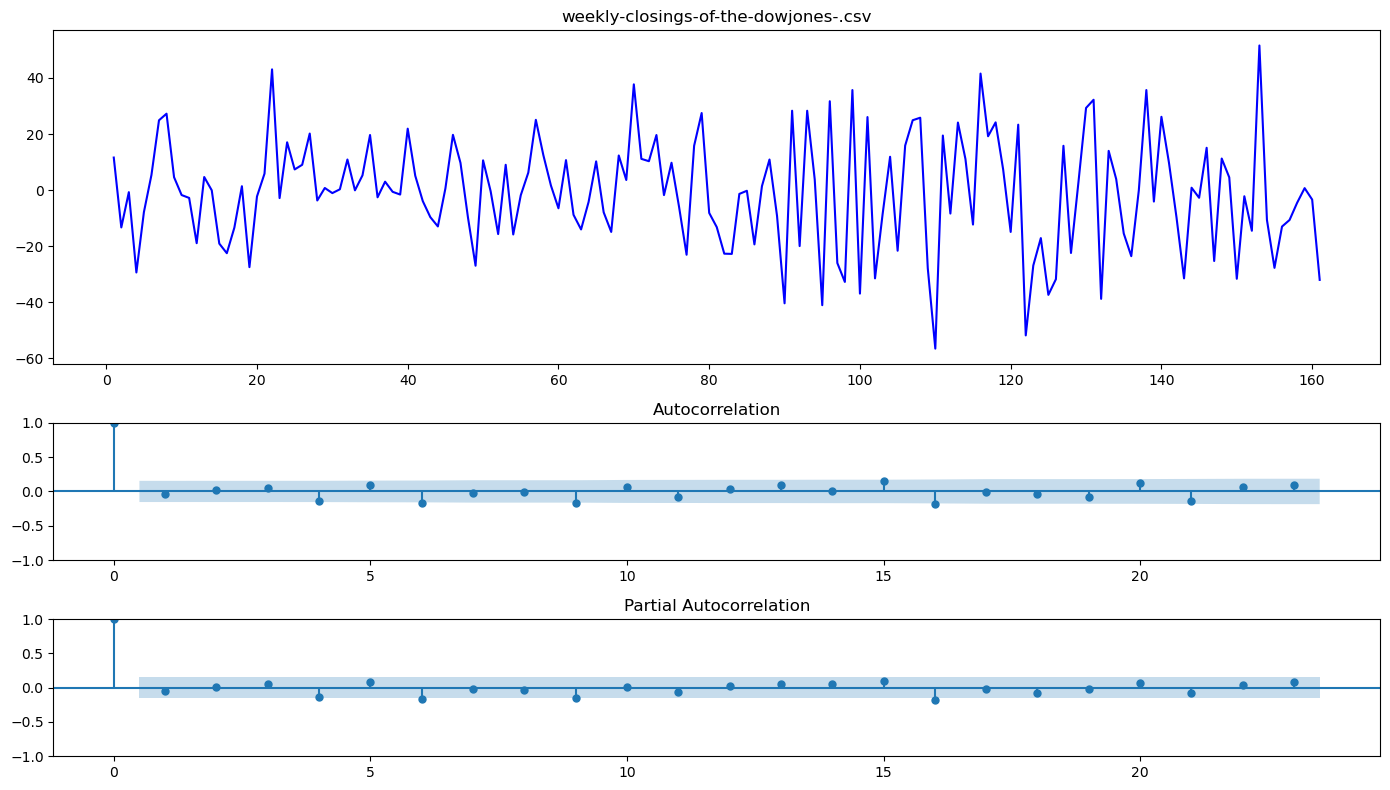

In [232]:
ds = DataSerie( ds_1['Close'], file_name )
ds.differencing(1)

ds.adfuller()
ds.corellogram()

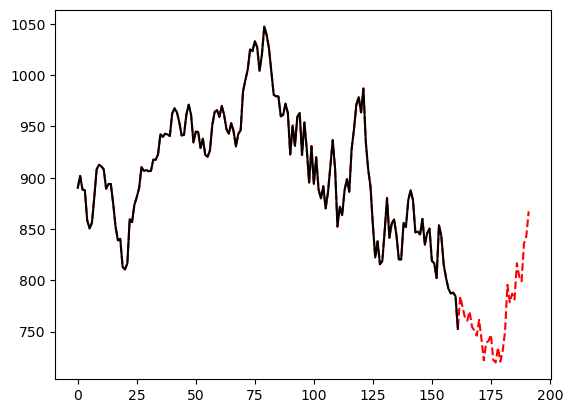

In [233]:
ds.predicting(30)

Пример 6

Index(['Date', 'Count'], dtype='object')
{'adf': -4.808291253559765, 'pvalue': 5.2434129901498554e-05, 'usedlag': 6, 'nobs': 358, 'is_stacionar': True, 'skew': 41.98082191780822}


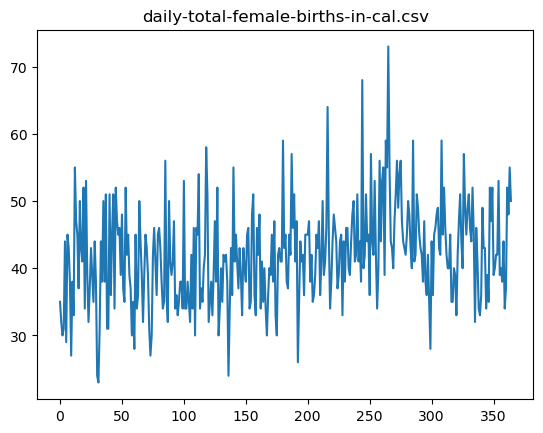

In [246]:
file_name = file_names[5]
ds_1 = pd.read_csv(file_name)
print( ds_1.columns )
ds = DataSerie( ds_1['Count'], file_name )
ds.adfuller()
ds.plot()

Если ряд стационарный - можно прогнозировать уже сразу, без преобразований

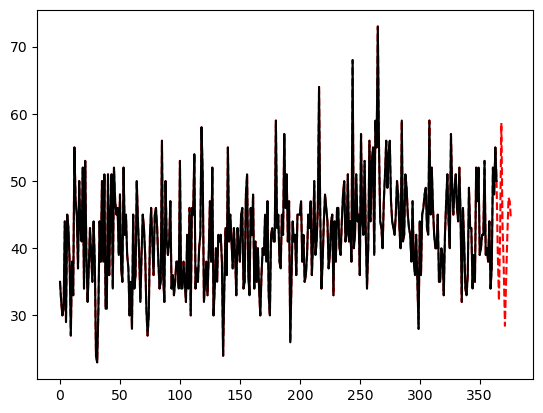

In [254]:
ds.predicting(12)

Пример прогноза на очень долгий срок

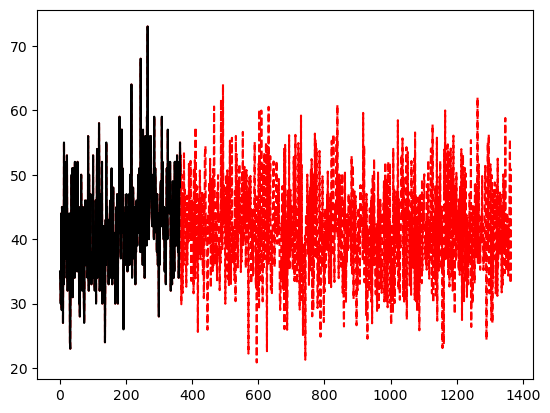

In [249]:
ds.predicting(1000)

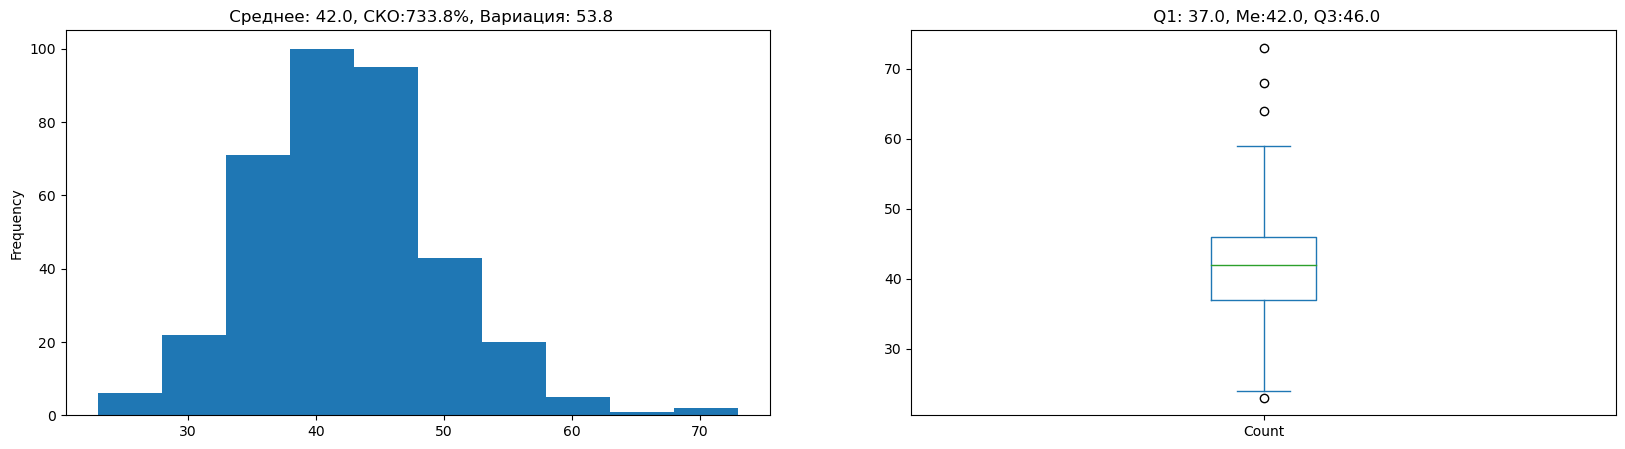

In [248]:
ds.plot_variation()

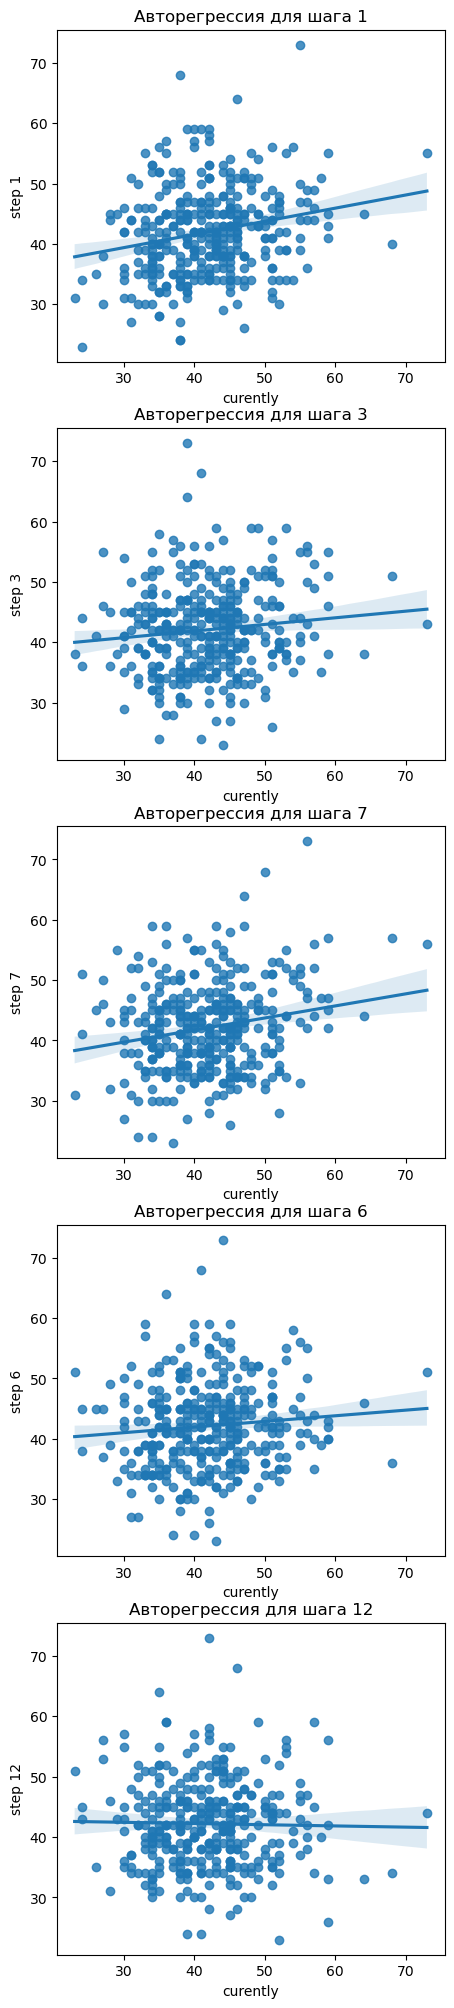

In [244]:
ds.plot_autoregression(lags=[1,3,7,6,12])